<a href="https://colab.research.google.com/github/RoyElkabetz/Tensor-Networks-Simple-Update/blob/main/Triangular_2d_lattice_BLBQ_Spin_1_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Tensor-Networks-Simple-Update
# add path to .py files for import
import sys
sys.path.insert(1, "/content/Tensor-Networks-Simple-Update/src")

Cloning into 'Tensor-Networks-Simple-Update'...
remote: Enumerating objects: 502, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 502 (delta 11), reused 7 (delta 5), pack-reused 483
Receiving objects: 100% (502/502), 1.46 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (292/292), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from TensorNetwork import TensorNetwork
import SimpleUpdate as su
import structure_matrix_generator as stmg
from tqdm.auto import tqdm


np.random.seed(216)

plt.rcParams.update({'font.size': 16, 
                     "figure.facecolor": 'white', 
                     "axes.facecolor": 'white', 
                     "savefig.facecolor": 'white', 
                     'savefig.edgecolor' : 'white', 
                     'figure.edgecolor' : 'white'})

# Spin-1 Simulation of a Bilinear-Biquadratic Heisenberg model on a triangular $2D$ lattice 

In [3]:
# The Tensor Network structure matrix
triangle_structure_matrix = stmg.infinite_structure_matrix_by_name('triangular')
print('The triangular 2D lattice structure matrix:')
print(triangle_structure_matrix)

The triangular 2D lattice structure matrix:
[[1 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 2 0 0 0 0 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 3 4 5 6 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 4 5 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 3 0 0 4 0 0 5 6 0 0 0]
 [0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 4 0 5 6 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 3 0 4 0 0 0 5 0 6]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 4 0 5 6]]


In [6]:
tri_tn = TensorNetwork(structure_matrix=triangle_structure_matrix, 
                       virtual_size=2, spin_dim=3)

In [7]:
# spin-1 operators
sx = np.array([[0., 1., 0.],
               [1., 0., 1.],
               [0., 1., 0.]]) / np.sqrt(2)
sy = np.array([[0., -1j, 0.],
               [1j, 0., -1j],
               [0., 1j, 0.]]) / np.sqrt(2)
sz = np.array([[1., 0., 0.],
               [0., 0., 0.],
               [0., 0., -1.]])

s_linear_term = [sx, sy, sz]
s_quad_term = [np.matmul(sx, sx), np.matmul(sy, sy), np.matmul(sz, sz),  
               np.matmul(sx, sy), np.matmul(sy, sx), np.matmul(sx, sz), 
               np.matmul(sz, sx), np.matmul(sz, sy), np.matmul(sy, sz)]

q0 = np.matmul(sx, sx) - np.matmul(sy, sy)
q1 = (np.matmul(sz, sz) - np.matmul(sx, sx) - np.matmul(sy, sy)) / np.sqrt(3)
q2 = np.matmul(sx, sy) + np.matmul(sy, sx)
q3 = np.matmul(sy, sz) + np.matmul(sz, sy)
q4 = np.matmul(sz, sy) + np.matmul(sy, sz)
q_operator = [q0, q1, q2, q3, q4]

# get the spin-spin interaction terms
interaction_linear_term = np.zeros((np.power(sx.shape[0], 2), np.power(sx.shape[0], 2)), dtype=np.complex)
interaction_quad_term = np.zeros((np.power(sx.shape[0], 2), np.power(sx.shape[0], 2)), dtype=np.complex)
for s in s_linear_term:
    interaction_linear_term += np.kron(s, s)
for s in s_quad_term:
    interaction_quad_term += np.kron(s, s)    

The BLBQ Hamiltonian is given by

\begin{align}
    H = \cos{\left(\theta\right)}\sum_{<i, j>} \mathbf{S}_i\cdot \mathbf{S}_j + \sin{\left(\theta\right)}\sum_{<i, j>} \left(\mathbf{S}_i\cdot \mathbf{S}_j\right)^2
\end{align}

In [11]:
# Simple-Update parameters
d_max_tri = [1, 2, 3]
error = 1e-6
max_iterations = 100
tri_energy = {}

tri_magnetization = {}
tri_quad = {}

j_ij = [-1.] * len(tri_tn.weights)
dts = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# set angle values in [0, 2pi]
theta = np.linspace(0, 2 * np.pi, 100)


# Run
for d_max in d_max_tri:
    tri_energy[d_max] = []
    tri_magnetization[d_max] = []
    tri_quad[d_max] = []
    for i, angle in tqdm(enumerate(theta)):
        hamiltonian = np.cos(angle) * interaction_linear_term + np.sin(angle) * interaction_quad_term

        tri_su = su.SimpleUpdate(tensor_network=tri_tn, 
                                  dts=dts, 
                                  j_ij=[], 
                                  h_k=0, 
                                  s_i=s_linear_term, 
                                  s_j=s_linear_term, 
                                  s_k=[], 
                                  d_max=d_max, 
                                  max_iterations=max_iterations, 
                                  convergence_error=error, 
                                  log_energy=False,
                                  print_process=False,
                                  hamiltonian=hamiltonian)
        tri_su.run()
        energy = tri_su.energy_per_site()
        magnetization = 0
        quad = 0
        for ten, _ in enumerate(tri_tn.tensors):
            magn_x = np.power(np.real(tri_su.tensor_expectation(ten, sx)), 2)
            magn_y = np.power(np.real(tri_su.tensor_expectation(ten, sy)), 2)
            magn_z = np.power(np.real(tri_su.tensor_expectation(ten, sz)), 2)
            magnetization += np.sqrt(magn_x + magn_y + magn_z)

            local_q = []
            for q in q_operator:
                local_q.append(np.power(np.real(tri_su.tensor_expectation(ten, q)), 2))
            quad += np.sqrt(np.sum(np.array(local_q)))

        
        magnetization /= len(tri_tn.tensors)
        quad /= len(tri_tn.tensors)
        print('| D max: {:3d} | Theta: {:2.6f} | Energy: {:3.10f} | Magnetization: {:3.10f} | quad: {:3.10f} |'
        .format(d_max, angle, energy, magnetization, quad))
        tri_energy[d_max].append(energy)
        tri_magnetization[d_max].append(magnetization)
        tri_quad[d_max].append(quad)
    

| D max:   1 | Theta: 0.000000 | Energy: -1.4997653625 | Magnetization: 0.9999846144 | quad: 0.3801497167 |
| D max:   1 | Theta: 0.330694 | Energy: 0.0808680942 | Magnetization: 0.9917635044 | quad: 0.3892207341 |
| D max:   1 | Theta: 0.661388 | Energy: 1.6035288860 | Magnetization: 0.9634594382 | quad: 0.4444957543 |
| D max:   1 | Theta: 0.992082 | Energy: 2.8770569266 | Magnetization: 0.8786287072 | quad: 0.5587683770 |
| D max:   1 | Theta: 1.322776 | Energy: 3.4722549122 | Magnetization: 0.4371653455 | quad: 0.7701968792 |
| D max:   1 | Theta: 1.653470 | Energy: 2.8049586467 | Magnetization: 0.9567123649 | quad: 0.7009056153 |
| D max:   1 | Theta: 1.984164 | Energy: 1.5422354617 | Magnetization: 1.0000000000 | quad: 0.7149835760 |
| D max:   1 | Theta: 2.314858 | Energy: 0.1753270171 | Magnetization: 1.0000000000 | quad: 0.7149844973 |
| D max:   1 | Theta: 2.645552 | Energy: -1.2105790745 | Magnetization: 1.0000000000 | quad: 0.7149844973 |
| D max:   1 | Theta: 2.976246 | En

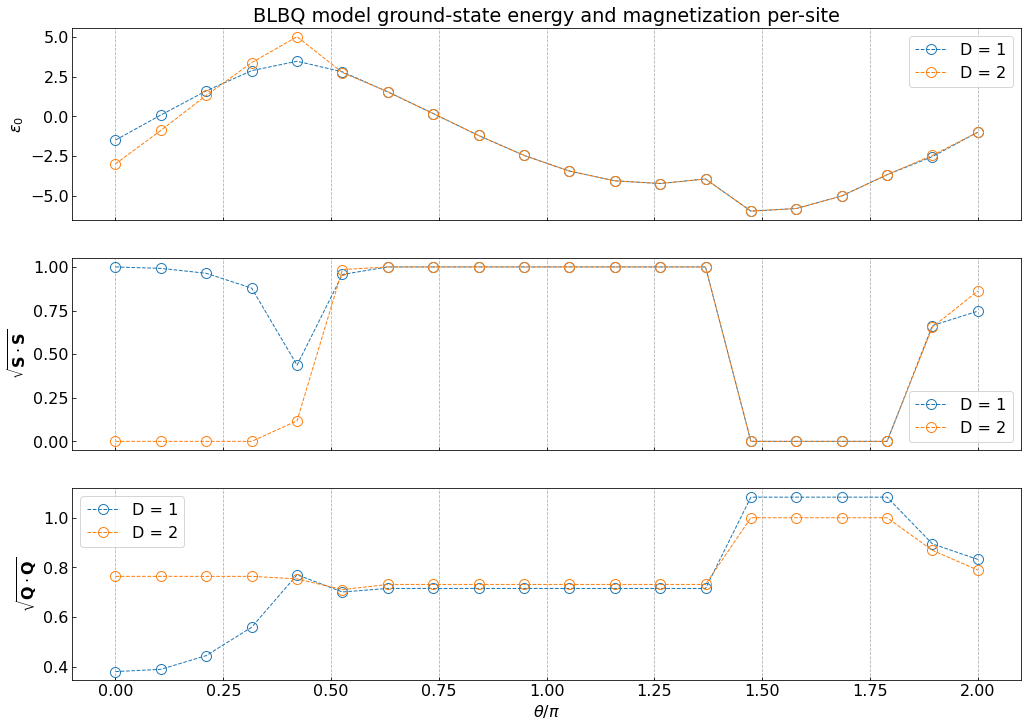

In [12]:
# color='tab:red'

fig, ax = plt.subplots(3, 1, figsize=(17, 12))
for d_max in d_max_tri:
    ax[0].plot(theta / np.pi, tri_energy[d_max], '--o', label=f'D = {d_max}', 
              markerfacecolor='none', linewidth=1, markersize=10)
    ax[0].set_xlabel('')
    ax[0].set_xticklabels([])
    ax[0].set_ylabel(r'$\epsilon_0$')
    ax[0].set_title('BLBQ model ground-state energy and magnetization per-site')
    ax[0].tick_params(direction='in', axis='both')
    ax[0].grid()
    ax[0].legend()
    ax[0].grid(which='major', axis='x', linestyle='--')


    ax[1].plot(theta / np.pi, tri_magnetization[d_max], '--o', label=f'D = {d_max}', 
               markerfacecolor='none', linewidth=1, markersize=10)
    ax[1].set_ylabel(r'$\sqrt{\mathbf{S}\cdot\mathbf{S}}$')
    ax[1].set_xlabel('')
    ax[1].set_xticklabels([])
    ax[1].tick_params(direction='in', axis='both')
    ax[1].grid()
    ax[1].legend()
    ax[1].grid(which='major', axis='x', linestyle='--')


    ax[2].plot(theta / np.pi, tri_quad[d_max], '--o', label=f'D = {d_max}', 
               markerfacecolor='none', linewidth=1, markersize=10)
    ax[2].set_xlabel(r'$\theta / \pi$')
    ax[2].set_ylabel(r'$\sqrt{\mathbf{Q}\cdot\mathbf{Q}}$')
    ax[2].tick_params(direction='in', axis='both')
    ax[2].grid()
    ax[2].legend()
    ax[2].grid(which='major', axis='x', linestyle='--')
